In [1]:
import time, sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18, 'figure.figsize': (25, 10), 'font.family': 'serif', 'text.usetex': True, 'pgf.rcfonts': False})

from smolyax import indices

sys.setrecursionlimit(11_000)

%load_ext autoreload
%autoreload 2

# Visualizing 2-D Multi-Index Sets

In [2]:
def print_indexset(t, k, d1, d2) :
    n1 = int(np.ceil(t/k[d1]))
    n2 = int(np.ceil(t/k[d2]))
    arr = [[' ' for _ in range(int(np.ceil(t/k[d2])))] for _ in range(n1)]
    i = indices.indexset(k, t)
    arr[0][0] = 'x'
    for idx in i :
        idx = dict(idx)
        if d1 in idx.keys() and d2 in idx.keys() :  arr[idx[d1]][idx[d2]] = 'x'
        if d1 in idx.keys() : arr[idx[d1]][0] = 'x'
        if d2 in idx.keys() : arr[0][idx[d2]] = 'x'

    for i in range(n1)[::-1]  :
        print('     +' + '---+'*len(arr[i]) + '\n {:3} | '.format(i), end='')
        for j in range(len(arr[i])) :
            print(arr[i][j] + ' | ', end='')
        print()
    print('     +' + '---+'*len(arr[-1]))
    print('       ', end='')
    for i in range(n2) : print(str(i) + '   ', end='')
    print()

t = 6
k = [np.log(j+2)/np.log(2) for j in range(2)]
print_indexset(t, k, 0, 1)

     +---+---+---+---+
   5 | x |   |   |   | 
     +---+---+---+---+
   4 | x | x |   |   | 
     +---+---+---+---+
   3 | x | x |   |   | 
     +---+---+---+---+
   2 | x | x | x |   | 
     +---+---+---+---+
   1 | x | x | x | x | 
     +---+---+---+---+
   0 | x | x | x | x | 
     +---+---+---+---+
       0   1   2   3   


# Visualizing Admissible Weight Sequences For Constructing High-dimensional Multi-Index Sets

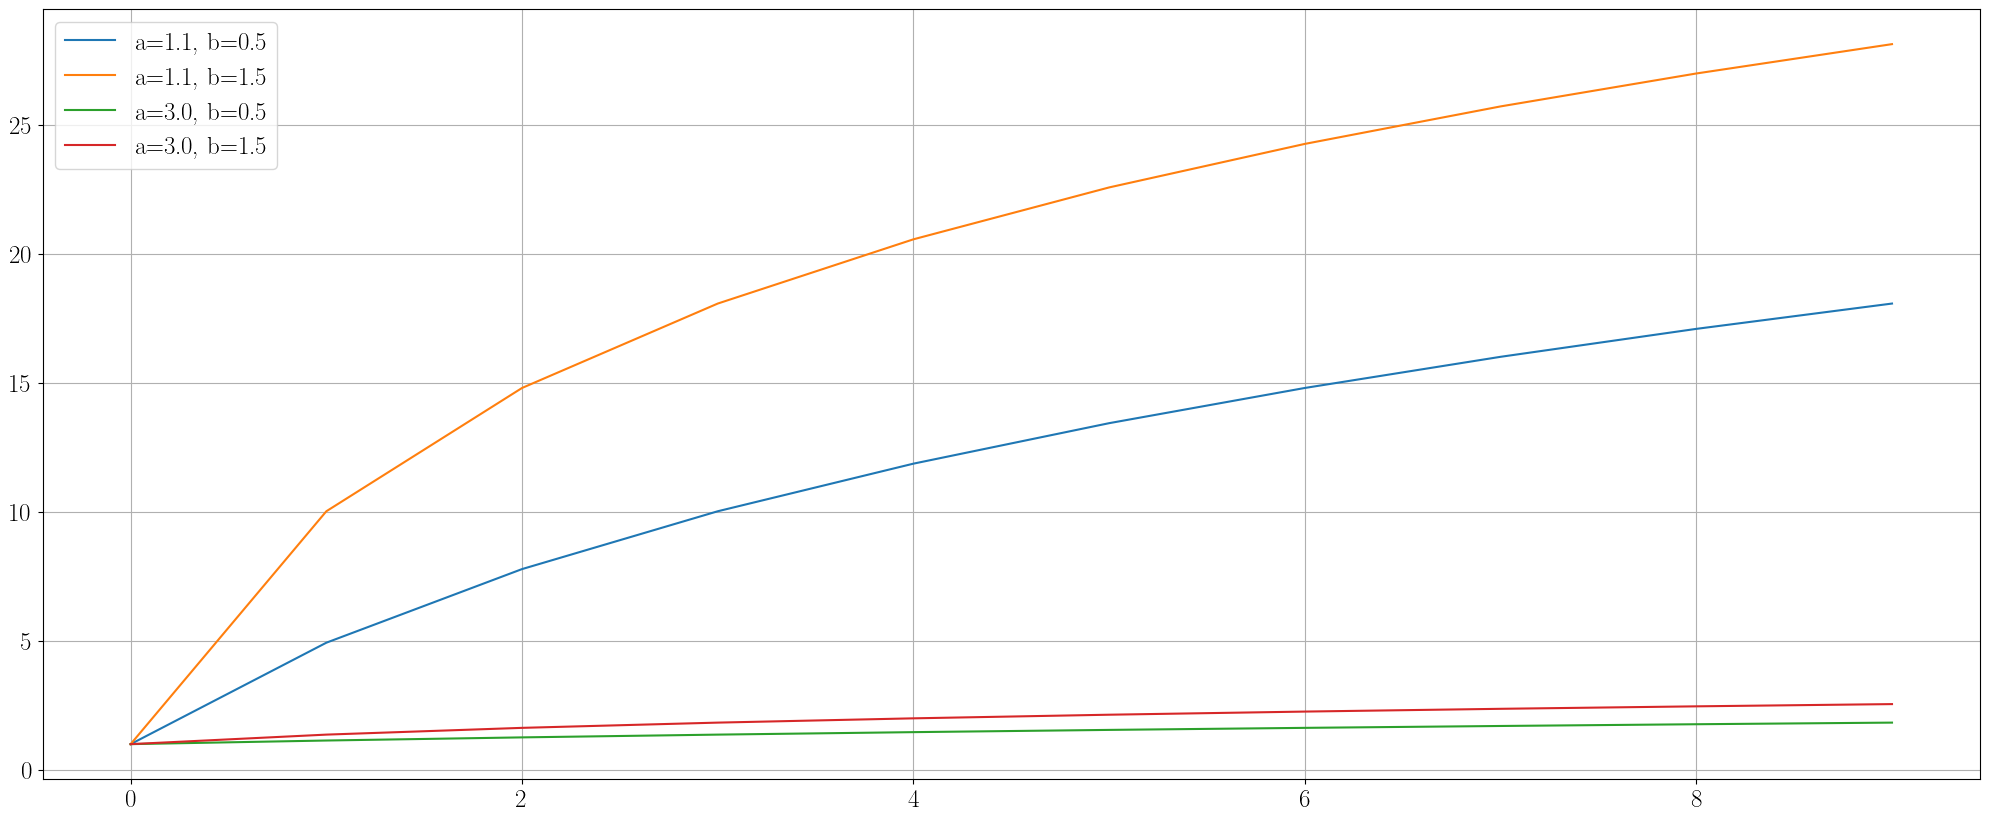

In [3]:
a_list = [1.1, 3.]
b_list = [.5, 1.5]
d = 10
x = np.array([i for i in range(d)])
for a in a_list :
    for b in b_list :
        plt.plot(x, np.log(a + b*x) / np.log(a + b*x[0]), label=f'a={a}, b={b}')
plt.legend(); plt.grid()

# Multi-index set construction time

In [4]:
dimensions = [10, 100, 1000, 10_000]
sizes = [300, 1_000, 3_000, 10_000, 30_000]
times = np.zeros((2, len(dimensions), len(sizes)))

for i, is_nested in enumerate([True, False]) :
    for j, d in enumerate(dimensions) :
        k = [np.log(j+2)/np.log(2) for j in range(d)]
    
        for l, m in enumerate(sizes) : 
            t = indices.find_approximate_threshold(k, m, is_nested)
        
            t_start = time.process_time()
            iset = indices.indexset(k, t)
            times[i,j,l] = time.process_time() - t_start

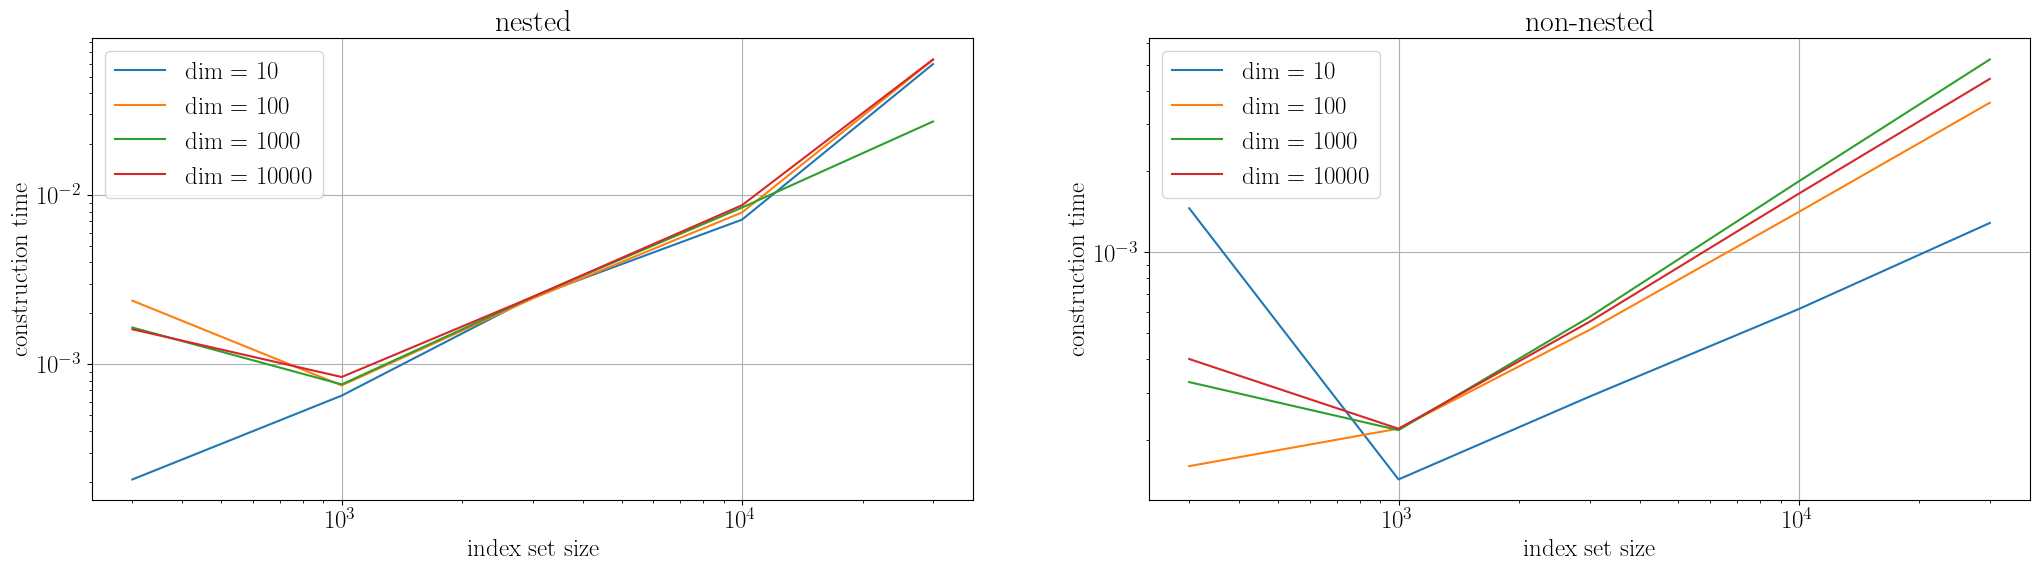

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(25,6))

for i, (ax, title) in enumerate(zip(axes, ['nested', 'non-nested'])) :
    for j, d in enumerate(dimensions) :
        ax.loglog(sizes, times[i,j,:], label=f'dim = {d}')
    ax.legend(); ax.grid(); ax.set_title(title); ax.set_xlabel('index set size'); ax.set_ylabel('construction time')

# Visualizing transformation of multi-indices

In [10]:
d = 4
k = [np.log(ki + 2) / np.log(2) for ki in range(d)]
t = 5.1

indxs = indices.indexset(k, t)

N = len(indxs)

zetas = [indices.smolyak_coefficient_zeta(k, t, nu=nu) for nu in indxs]
indxs_z = [nu for nu, z in zip(indxs, zetas) if z != 0]

taus = {}
for nu in indxs_z:
    tau = tuple(sorted((v for _, v in nu), reverse=True))
    n = len(tau)
    taus[n] = tuple(max(tau1, tau2) for tau1, tau2 in zip(taus.get(n, tau), tau))
taus = list(taus.values())

indxs_z += [None] * (N - len(indxs_z))
taus += [None] * (N - len(taus))

print('| LAMBDA (dense) |  LAMBDA (sparse)   | LAMBDA (nonzero) | ZETA |    | LAMBDA_ZETA -> sort    -> max       |')
print('+----------------+--------------------+------------------+------+    +-------------------------------------+')

lines = []
for nu, z, nu_z, tau in zip(indxs, zetas, indxs_z, taus):
    l = f'|  {indices.sparse_index_to_dense(nu, dim=d)}  | {str(dict(nu)):<18} | {str(tuple(v for _, v in nu)):<16} | {z:>3}  |    '
    if nu_z is not None:
        l += f'|  {str(tuple(v for _, v in nu_z)):<13}'
        l += f' {str(tuple(sorted((v for _, v in nu_z), reverse=True))):<9} '
        if tau is not None:
            l += f' {str(tau):<9} |'
        else:
            l += f'           |'
    print(l)

| LAMBDA (dense) |  LAMBDA (sparse)   | LAMBDA (nonzero) | ZETA |    | LAMBDA_ZETA -> sort    -> max       |
+----------------+--------------------+------------------+------+    +-------------------------------------+
|  (5, 0, 0, 0)  | {0: 5}             | (5,)             |   1  |    |  (5,)          (5,)       (5,)      |
|  (4, 0, 0, 0)  | {0: 4}             | (4,)             |   0  |    |  (3, 1)        (3, 1)     (3, 1)    |
|  (3, 1, 0, 0)  | {0: 3, 1: 1}       | (3, 1)           |   1  |    |  (3,)          (3,)       (1, 1, 1) |
|  (3, 0, 0, 0)  | {0: 3}             | (3,)             |  -2  |    |  (3, 1)        (3, 1)     ()        |
|  (3, 0, 1, 0)  | {0: 3, 2: 1}       | (3, 1)           |   1  |    |  (2,)          (2,)                 |
|  (2, 1, 0, 0)  | {0: 2, 1: 1}       | (2, 1)           |   0  |    |  (2, 1)        (2, 1)               |
|  (2, 0, 1, 0)  | {0: 2, 2: 1}       | (2, 1)           |   0  |    |  (1, 2)        (2, 1)               |
|  (2, 0, 0, 0)  | 